In [3]:
from kloppy import skillcorner
import pandas as pd
import numpy as np

import requests
import json

# import mplsoccer 
# Setup pitch and plot
from mplsoccer import Pitch, VerticalPitch

In [2]:
match_id = 1886347

dataset = skillcorner.load_open_data(
    match_id=match_id,    # Optional Parameters
    coordinates="skillcorner",  # or specify a different coordinate system
    sample_rate= (1/2),  # changes the data from 10fps to 5fps
    limit=100,  # only load the first 100 frames
)

In [8]:
type(dataset)

kloppy.domain.models.tracking.TrackingDataset

In [10]:
df = (
    dataset.transform(to_orientation="STATIC_HOME_AWAY")  # Now, all attacks happen from left to right
    .filter(lambda frame: frame.period.id == 1)  # Only keep frames from the first half
    .to_df(engine="polars")  # Convert to a Polars DataFrame, or use engine="pandas" for a Pandas DataFrame
)

## Using the Raw Data Pull (SkillCorner Tutorials)

In [4]:
match_id = 1886347
# Construct the raw GitHub URL
tracking_url = f"https://media.githubusercontent.com/media/SkillCorner/opendata/master/data/matches/{match_id}/{match_id}_tracking_extrapolated.jsonl"
raw_data = pd.read_json(tracking_url, lines=True)


In [5]:
raw_data.iloc[10,:]

frame                                                                      10
timestamp                                                 2025-12-03 00:00:00
period                                                                    1.0
ball_data                   {'x': 0.32, 'y': 0.38, 'z': 0.13, 'is_detected...
possession                                 {'player_id': None, 'group': None}
image_corners_projection    {'x_top_left': -52.52, 'y_top_left': 39.0, 'x_...
player_data                 [{'x': -39.63, 'y': -0.08, 'player_id': 51009,...
Name: 10, dtype: object

In [6]:
# Transform the data to observation level data that we can further manipulate for future analysis
raw_df = pd.json_normalize(
    raw_data.to_dict("records"),
    "player_data",
    ["frame", "timestamp", "period", "possession", "ball_data"],
)

display(raw_df.shape)
raw_df.head()

(956076, 9)

,x,y,player_id,is_detected,frame,timestamp,period,possession,ball_data
0,-39.63,-0.08,51009,False,10,2025-12-03,1.0,"{'player_id': None, 'group': None}","{'x': 0.32, 'y': 0.38, 'z': 0.13, 'is_detected..."
1,-19.21,-9.18,176224,True,10,2025-12-03,1.0,"{'player_id': None, 'group': None}","{'x': 0.32, 'y': 0.38, 'z': 0.13, 'is_detected..."
2,-21.83,0.47,51649,True,10,2025-12-03,1.0,"{'player_id': None, 'group': None}","{'x': 0.32, 'y': 0.38, 'z': 0.13, 'is_detected..."
3,-1.16,-32.47,50983,True,10,2025-12-03,1.0,"{'player_id': None, 'group': None}","{'x': 0.32, 'y': 0.38, 'z': 0.13, 'is_detected..."
4,-18.88,15.73,735578,True,10,2025-12-03,1.0,"{'player_id': None, 'group': None}","{'x': 0.32, 'y': 0.38, 'z': 0.13, 'is_detected..."


In [7]:
# Extract 'player_id' and 'group from the 'possession' column which is a dictionary in the dataframe
raw_df["possession_player_id"] = raw_df["possession"].apply(lambda x : x.get("player_id"))
raw_df["possession_group"] = raw_df["possession"].apply(lambda x : x.get("group"))

raw_df.head(3)

,x,y,player_id,is_detected,frame,timestamp,period,possession,ball_data,possession_player_id,possession_group
0,-39.63,-0.08,51009,False,10,2025-12-03,1.0,"{'player_id': None, 'group': None}","{'x': 0.32, 'y': 0.38, 'z': 0.13, 'is_detected...",NaN,None
1,-19.21,-9.18,176224,True,10,2025-12-03,1.0,"{'player_id': None, 'group': None}","{'x': 0.32, 'y': 0.38, 'z': 0.13, 'is_detected...",NaN,None
2,-21.83,0.47,51649,True,10,2025-12-03,1.0,"{'player_id': None, 'group': None}","{'x': 0.32, 'y': 0.38, 'z': 0.13, 'is_detected...",NaN,None


In [8]:
# (Optional) Expand the ball_data with json_normalize
# This gives us the coordinates of the ball!
raw_df[["ball_x", "ball_y", "ball_z", "is_detected_ball"]] = pd.json_normalize(raw_df.ball_data)
raw_df.head(1)

,x,y,player_id,is_detected,frame,timestamp,period,possession,ball_data,possession_player_id,possession_group,ball_x,ball_y,ball_z,is_detected_ball
0,-39.63,-0.08,51009,False,10,2025-12-03,1.0,"{'player_id': None, 'group': None}","{'x': 0.32, 'y': 0.38, 'z': 0.13, 'is_detected...",NaN,None,0.32,0.38,0.13,True


In [9]:
raw_df["possession_player_id"].isna().sum() # not all observations will involve a possession id since they might not be in possesion

np.int64(725362)

In [ ]:
# (Optional) Drop the original 'possession' column if you no longer need it
raw_df = raw_df.drop(columns=["possession", "ball_data"])

# Add the match_id identifier to your dataframe
raw_df["match_id"] = match_id
tracking_df = raw_df.copy()
tracking_df.head()

del raw_df

In [11]:
tracking_df.head(5)

,x,y,player_id,is_detected,frame,timestamp,period,possession_player_id,possession_group,ball_x,ball_y,ball_z,is_detected_ball,match_id
0,-39.63,-0.08,51009,False,10,2025-12-03,1.0,NaN,None,0.32,0.38,0.13,True,1886347
1,-19.21,-9.18,176224,True,10,2025-12-03,1.0,NaN,None,0.32,0.38,0.13,True,1886347
2,-21.83,0.47,51649,True,10,2025-12-03,1.0,NaN,None,0.32,0.38,0.13,True,1886347
3,-1.16,-32.47,50983,True,10,2025-12-03,1.0,NaN,None,0.32,0.38,0.13,True,1886347
4,-18.88,15.73,735578,True,10,2025-12-03,1.0,NaN,None,0.32,0.38,0.13,True,1886347


### Get Metadata

In [15]:
def time_to_seconds(time_str):
    if time_str is None:
        return 90 * 60  # 120 minutes = 7200 seconds
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s

In [12]:
match_id = 1886347
meta_data_github_url = f"https://raw.githubusercontent.com/SkillCorner/opendata/master/data/matches/{match_id}/{match_id}_match.json"
# Read the JSON data as a JSON object
response = requests.get(meta_data_github_url)
raw_match_data = response.json()

# The output has nested json elements. We process them
raw_match_df = pd.json_normalize(raw_match_data, max_level=2)
raw_match_df["home_team_side"] = raw_match_df["home_team_side"].astype(str)
raw_match_df.head(1)

,id,home_team_score,away_team_score,date_time,home_team_coach,away_team_coach,match_periods,referees,players,status,...,competition_edition.season.id,competition_edition.season.start_year,competition_edition.season.end_year,competition_edition.season.name,competition_edition.name,competition_round.id,competition_round.name,competition_round.round_number,competition_round.potential_overtime,ball.trackable_object
0,1886347,2,0,2024-11-30T04:00:00Z,None,None,"[{'period': 1, 'name': 'period_1', 'start_fram...",[],"[{'player_role': {'id': 15, 'position_group': ...",closed,...,95,2024,2025,2024/2025,AUS - A-League - 2024/2025,611,Round 6,6,False,55


In [17]:
players_df = pd.json_normalize(
    raw_match_df.to_dict("records"), 
    record_path="players", 
    meta=[
        "home_team_score",
        "away_team_score",
        "date_time",
        "home_team_side",
        "home_team.name",
        "home_team.id",
        "away_team.name",
        "away_team.id",
    ],  # data we keep
)

# Take only players who played and create their total time
players_df = players_df[~((players_df.start_time.isna()) & (players_df.end_time.isna()))] # filter for players who have played
players_df["total_time"] = players_df["end_time"].apply(time_to_seconds) - players_df["start_time"].apply(time_to_seconds) # calculating playing time
# players_df["total_time_mins"] = (players_df["total_time"] * 1.0) / 60.0

# Create a flag for GK
players_df["is_gk"] = players_df["player_role.acronym"] == "GK" # create a boolean that lets us know if the player is a GK

# Create a match name variable
players_df["match_name"] = (players_df["home_team.name"] + " vs " + players_df["away_team.name"]) # create the name of the match

# Add a flag if the given player is home or away
players_df["home_away_player"] = np.where(players_df.team_id == players_df["home_team.id"], "Home", "Away") # Categorical

# Create flag from player
players_df["team_name"] = np.where(players_df.team_id == players_df["home_team.id"], players_df["home_team.name"], players_df["away_team.name"],)

# Figure out sides
players_df[["home_team_side_1st_half", "home_team_side_2nd_half"]] = (
    players_df["home_team_side"]
    .astype(str)
    .str.strip("[]")
    .str.replace("'", "")
    .str.split(", ", expand=True)
)

# Clean up sides
players_df["direction_player_1st_half"] = np.where(
    players_df.home_away_player == "Home",
    players_df.home_team_side_1st_half,
    players_df.home_team_side_2nd_half,
)
players_df["direction_player_2nd_half"] = np.where(
    players_df.home_away_player == "Home",
    players_df.home_team_side_2nd_half,
    players_df.home_team_side_1st_half,
)

players_df["match_id"] = match_id

# Clean up and keep the columns that we want to keep for our metadata

columns_to_keep = [
    "start_time",
    "end_time",
    "match_name",
    "match_id",
    "date_time",
    "home_team.name",
    "away_team.name",
    "id",
    "short_name",
    "number",
    "team_id",
    "team_name",
    "player_role.position_group",
    "total_time",
    "player_role.name",
    "player_role.acronym",
    "is_gk",
    "direction_player_1st_half",
    "direction_player_2nd_half",
]
players_df = players_df[columns_to_keep]
players_df.head(3)

,start_time,end_time,match_name,match_id,date_time,home_team.name,away_team.name,id,short_name,number,team_id,team_name,player_role.position_group,total_time,player_role.name,player_role.acronym,is_gk,direction_player_1st_half,direction_player_2nd_half
0,00:00:00,01:25:21,Auckland FC vs Newcastle United Jets FC,1886347,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,38673,G. May,10,4177,Auckland FC,Center Forward,5121,Center Forward,CF,False,right_to_left,left_to_right
1,00:00:00,None,Auckland FC vs Newcastle United Jets FC,1886347,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,51713,C. Elliott,17,4177,Auckland FC,Full Back,5400,Right Back,RB,False,right_to_left,left_to_right
2,00:00:00,01:16:37,Auckland FC vs Newcastle United Jets FC,1886347,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,50951,J. Brimmer,22,4177,Auckland FC,Center Forward,4597,Center Forward,CF,False,right_to_left,left_to_right


In [18]:
# Merging datasets
enriched_tracking_data = tracking_df.merge(
    players_df, left_on=["player_id", "match_id"], right_on=["id", "match_id"]
)
enriched_tracking_data.head()

,x,y,player_id,is_detected,frame,timestamp,period,possession_player_id,possession_group,ball_x,...,number,team_id,team_name,player_role.position_group,total_time,player_role.name,player_role.acronym,is_gk,direction_player_1st_half,direction_player_2nd_half
0,-39.63,-0.08,51009,False,10,2025-12-03,1.0,NaN,None,0.32,...,1,1805,Newcastle United Jets FC,Other,5400,Goalkeeper,GK,True,left_to_right,right_to_left
1,-19.21,-9.18,176224,True,10,2025-12-03,1.0,NaN,None,0.32,...,4,1805,Newcastle United Jets FC,Central Defender,5400,Right Center Back,RCB,False,left_to_right,right_to_left
2,-21.83,0.47,51649,True,10,2025-12-03,1.0,NaN,None,0.32,...,15,1805,Newcastle United Jets FC,Central Defender,5400,Left Center Back,LCB,False,left_to_right,right_to_left
3,-1.16,-32.47,50983,True,10,2025-12-03,1.0,NaN,None,0.32,...,14,1805,Newcastle United Jets FC,Full Back,5400,Right Back,RB,False,left_to_right,right_to_left
4,-18.88,15.73,735578,True,10,2025-12-03,1.0,NaN,None,0.32,...,33,1805,Newcastle United Jets FC,Full Back,5400,Left Back,LB,False,left_to_right,right_to_left


In [19]:
# Filtering for frames with a team in possession
filtered_df = enriched_tracking_data[enriched_tracking_data["possession_group"].notnull()].copy()

# We basically want to convert the X and Y to make sure we're always visualizing left to right. A player's XY will depend on the half so the straight average doesn't work
filtered_df["direction_player"] = np.where(
    filtered_df["period"] == 1,
    filtered_df["direction_player_1st_half"],
    filtered_df["direction_player_2nd_half"],
)
# When going right to left, we flip the coordinates (We want our analysis to go from left to right)
filtered_df["x"] = np.where(
    filtered_df["direction_player"] == "right_to_left",
    -filtered_df["x"], # when going right to left, flip coordinates
    filtered_df["x"],
)  # Convert X

filtered_df["y"] = np.where(
    filtered_df["direction_player"] == "right_to_left",
    -filtered_df["y"], # when going right to left, flip coordinates
    filtered_df["y"],
)  # Convert Y

# Create some flags in case we need them later
filtered_df["possession_team_name"] = np.where(
    filtered_df["possession_group"] == "home team",
    filtered_df["home_team.name"],
    filtered_df["away_team.name"],
)

filtered_df["possession_flag"] = np.where(
    filtered_df["possession_team_name"] == filtered_df["team_name"], 
    "IP", # In Possession
    "OOP" # Out of Possession
)

# At this point all of our players have their X and Y adjusted from left to right , so we can aggregate for across the game to get their average position during the game
aggregated_df = (
    filtered_df.groupby(
        [
            "player_id",
            "possession_group",
            "team_name",
            "possession_team_name",
            "possession_flag",  # This will allow us to check the position of the player when the team is in or out of possession
            "start_time",  # With this we can filter in or out the players that came on as subs
            "number",
            "is_gk",
        ]
    )[["x", "y"]]
    .mean()
    .reset_index()
)

aggregated_df.sort_values(["possession_flag", "team_name"]).head(5)

,player_id,possession_group,team_name,possession_team_name,possession_flag,start_time,number,is_gk,x,y
1,14736,home team,Auckland FC,Auckland FC,IP,00:00:00,6,False,5.181767,-4.093078
3,23418,home team,Auckland FC,Auckland FC,IP,00:00:00,28,False,7.095420,8.334144
5,31147,home team,Auckland FC,Auckland FC,IP,01:25:21,5,False,-9.197614,0.121759
7,33697,home team,Auckland FC,Auckland FC,IP,00:00:00,4,False,-6.836360,8.199158
9,38673,home team,Auckland FC,Auckland FC,IP,00:00:00,10,False,21.607955,-0.350817


Text(0.5, 1.0, 'Auckland FC Average Positions in Possession')

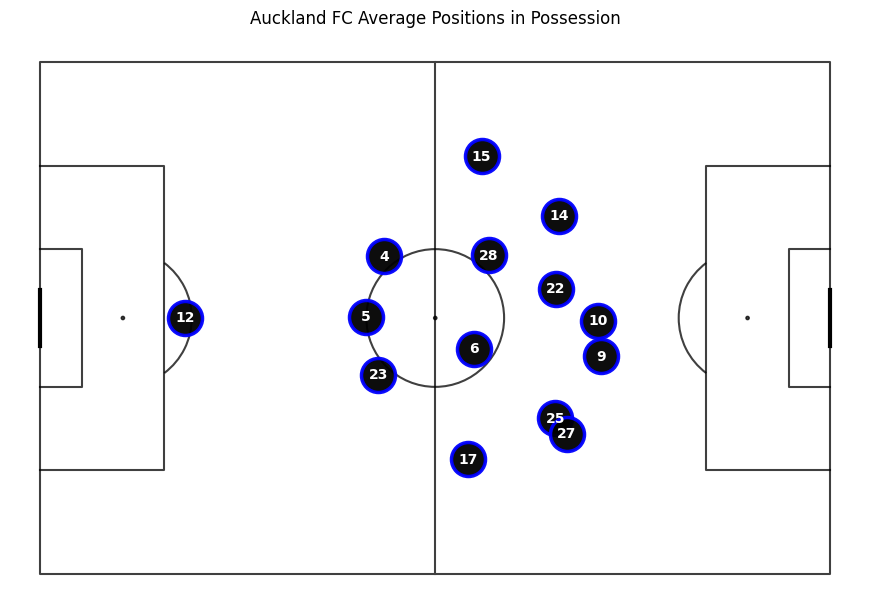

In [28]:
# Visualizing the data on a pitch

pitch = Pitch(
    pitch_type="skillcorner",
    line_alpha=0.75,
    pitch_length=105,
    pitch_width=68,
    pitch_color="white",
    line_color="black",
    linewidth=1.5,
)
fig, ax = pitch.grid(figheight=8, endnote_height=0, title_height=0)


# What to visualize
possession = "OOP"  # or 'OOP'
possession = "IP"
team = aggregated_df.team_name.unique().tolist()[
    0
]  # Pick one team, you can use the name directly

viz_ip = aggregated_df[
    (aggregated_df["possession_flag"] == possession)
    & (aggregated_df["team_name"] == team)
].reset_index(drop=True)


ax.scatter(
    viz_ip["x"],
    viz_ip["y"],
    c="black",
    alpha=0.95,
    s=600,
    edgecolors="blue",
    linewidths=2.5,
    zorder=10,
    label="team",
)


# Annotate player numbers
for i, row in viz_ip.iterrows():
    ax.text(
        row["x"],
        row["y"],
        str(row["number"]),
        color="white",
        fontweight="bold",
        fontsize=10,
        ha="center",
        va="center",
        zorder=16,
    )

ax.set_title(f"{team} Average Positions in Possession")

# fig.savefig("my_visualised_tracking_data.png", dpi=300, format="png")

In [21]:
filtered_df.head(5)

,x,y,player_id,is_detected,frame,timestamp,period,possession_player_id,possession_group,ball_x,...,player_role.position_group,total_time,player_role.name,player_role.acronym,is_gk,direction_player_1st_half,direction_player_2nd_half,direction_player,possession_team_name,possession_flag
396,-40.71,-0.27,51009,False,28,2025-12-03 00:00:01.800,1.0,966120.0,away team,0.03,...,Other,5400,Goalkeeper,GK,True,left_to_right,right_to_left,left_to_right,Newcastle United Jets FC,IP
397,-19.33,-9.63,176224,True,28,2025-12-03 00:00:01.800,1.0,966120.0,away team,0.03,...,Central Defender,5400,Right Center Back,RCB,False,left_to_right,right_to_left,left_to_right,Newcastle United Jets FC,IP
398,-21.72,0.22,51649,True,28,2025-12-03 00:00:01.800,1.0,966120.0,away team,0.03,...,Central Defender,5400,Left Center Back,LCB,False,left_to_right,right_to_left,left_to_right,Newcastle United Jets FC,IP
399,-0.64,-33.03,50983,True,28,2025-12-03 00:00:01.800,1.0,966120.0,away team,0.03,...,Full Back,5400,Right Back,RB,False,left_to_right,right_to_left,left_to_right,Newcastle United Jets FC,IP
400,-20.11,15.75,735578,True,28,2025-12-03 00:00:01.800,1.0,966120.0,away team,0.03,...,Full Back,5400,Left Back,LB,False,left_to_right,right_to_left,left_to_right,Newcastle United Jets FC,IP


In [22]:
filtered_df["possession_flag"].value_counts()

possession_flag
IP     346742
OOP    346742
Name: count, dtype: int64

### Dynamic Events

In [30]:
match_id = 1886347
de_match = pd.read_csv(f"https://raw.githubusercontent.com/SkillCorner/opendata/master/data/matches/{match_id}/{match_id}_dynamic_events.csv")

In [ ]:
de_match

In [ ]:
de_match["event_type"].unique()

,event_id,index,match_id,frame_start,frame_end,frame_physical_start,time_start,time_end,minute_start,second_start,...,xloss_player_possession_end,xloss_player_possession_max,xshot_player_possession_start,xshot_player_possession_end,xshot_player_possession_max,is_player_possession_start_matched,is_player_possession_end_matched,is_previous_pass_matched,is_pass_reception_matched,fully_extrapolated
0,8_0,0,1886347,28,28,NaN,00:01.8,00:01.8,0,1,...,NaN,NaN,NaN,NaN,NaN,True,True,NaN,True,False
1,8_1,1,1886347,48,58,NaN,00:03.8,00:04.8,0,3,...,NaN,NaN,NaN,NaN,NaN,True,True,True,True,False
2,7_0,2,1886347,48,53,NaN,00:03.8,00:04.3,0,3,...,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN,False
3,7_1,3,1886347,48,58,NaN,00:03.8,00:04.8,0,3,...,NaN,NaN,NaN,NaN,NaN,True,True,NaN,True,False


In [ ]:
print(1)